# Plotting t_SNE on Amazon Fine Food Reviews

In [1]:

#Importing required libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Narasimhulu\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('F:\Python\Data Sets\database.sqlite')

#filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def partition(x):
    if x<3:
        return'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

# Exploratory Data Analysis

# Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was
necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an
example:


In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for
HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was
found that
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and
so on
It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same
product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate
the rows having same parameters.
The method used for the same was that we first sort the data according to ProductId and then just keep the first
similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ
remains. This method ensures that there is only one representative for each product and deduplication without
sorting would lead to possibility of different representatives still existing for the same product.
In [

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"
}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

# Observation:- 
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than
HelpfulnessDenominator which is not practically possible hence these two rows too are removed from
calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [12]:
# Taking only 2000 positive points as suggested in the assignment because of memore issue.

final_positive=final[final['Score']=='positive']
final_positive=final_positive.head(2000)
print(final_positive.shape)
type(final_positive)


(2000, 10)


pandas.core.frame.DataFrame

In [13]:
# Taking only 2000 negative points as suggested in the assignment because of memore issue.

final_negative=final[final['Score']=='negative']
final_negative=final_negative.head(2000)
print(final_negative.shape)
type(final_negative)


(2000, 10)


pandas.core.frame.DataFrame

In [14]:
# Merging 2 dataframes so that the final dataframe will have 4000 points of each class:postive and negative

final_postive_negative=pd.concat([final_positive,final_negative])
print(final_postive_negative.shape)
print(type(final_postive_negative))

                    

(4000, 10)
<class 'pandas.core.frame.DataFrame'>


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final_postive_negative['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords

#Removing stopword 'not'
stop.remove('not')


sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Narasimhulu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"it's", 'yours', 'am', 'again', 'than', "wouldn't", "didn't", 'hers', 've', 'now', 'isn', 'does', 'haven', 'the', 'hadn', 'have', 'its', 'for', 'after', 'can', 'above', 'such', 'so', 'because', 'only', "hasn't", 'yourself', 'very', 'will', 'do', 'as', 'that', "don't", 'was', 'ma', 'at', 'any', 'i', 'to', "you'll", 'into', "weren't", 'which', 'between', 'other', 'how', 'further', "haven't", 'weren', "mustn't", "mightn't", 'd', 'by', 'during', 'doesn', 'wouldn', 'off', 'who', 'mustn', 'what', 'having', 'had', 'don', 'couldn', "won't", 'them', 'whom', 'if', 'each', 'were', 'should', 'themselves', "you're", 'out', 'mightn', 'shouldn', 'itself', 't', 'more', "shan't", 'are', "doesn't", 'being', 'my', 'it', 'in', "isn't", 'those', 'ourselves', 'she', 'her', 'this', 'too', 'from', 'you', "needn't", 'there', 'own', 'of', 'be', 'h

In [17]:
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final_postive_negative['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final_postive_negative['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final_postive_negative['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 372.68it/s]


In [18]:
final_string

[b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
 b'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open',
 b'fun way children learn month year learn poem throughout school year like handmot invent poem',
 b'great littl book read nice rhythm well good repetit littl one like line chicken soup rice child get month year wonder place like bombay nile eat well know get eat kid mauric sendak version ice skate treat rose head long time wont even know came surpris came littl witti book',
 b'book poetri month year goe month cute littl poem along love book realli fun way learn month poem creativ author purpos write book give children fun way learn month children also learn thing poetri rhythm read book',
 b'charm rhyme book describ circumst eat do

In [19]:
all_positive_words

[b'witti',
 b'littl',
 b'book',
 b'make',
 b'son',
 b'laugh',
 b'loud',
 b'recit',
 b'car',
 b'drive',
 b'along',
 b'alway',
 b'sing',
 b'refrain',
 b'hes',
 b'learn',
 b'whale',
 b'india',
 b'droop',
 b'love',
 b'new',
 b'word',
 b'book',
 b'introduc',
 b'silli',
 b'classic',
 b'book',
 b'will',
 b'bet',
 b'son',
 b'still',
 b'abl',
 b'recit',
 b'memori',
 b'colleg',
 b'grew',
 b'read',
 b'sendak',
 b'book',
 b'watch',
 b'realli',
 b'rosi',
 b'movi',
 b'incorpor',
 b'love',
 b'son',
 b'love',
 b'howev',
 b'miss',
 b'hard',
 b'cover',
 b'version',
 b'paperback',
 b'seem',
 b'kind',
 b'flimsi',
 b'take',
 b'two',
 b'hand',
 b'keep',
 b'page',
 b'open',
 b'fun',
 b'way',
 b'children',
 b'learn',
 b'month',
 b'year',
 b'learn',
 b'poem',
 b'throughout',
 b'school',
 b'year',
 b'like',
 b'handmot',
 b'invent',
 b'poem',
 b'great',
 b'littl',
 b'book',
 b'read',
 b'nice',
 b'rhythm',
 b'well',
 b'good',
 b'repetit',
 b'littl',
 b'one',
 b'like',
 b'line',
 b'chicken',
 b'soup',
 b'rice',
 b

In [20]:
all_negative_words

[b'one',
 b'best',
 b'children',
 b'book',
 b'ever',
 b'written',
 b'mini',
 b'version',
 b'book',
 b'not',
 b'portray',
 b'one',
 b'price',
 b'product',
 b'sent',
 b'email',
 b'regard',
 b'bewilder',
 b'amazon',
 b'got',
 b'respons',
 b'give',
 b'five',
 b'star',
 b'mauric',
 b'sendak',
 b'stori',
 b'one',
 b'star',
 b'print',
 b'edit',
 b'book',
 b'children',
 b'older',
 b'copi',
 b'book',
 b'familiar',
 b'previous',
 b'softcov',
 b'version',
 b'order',
 b'granddaught',
 b'embarrass',
 b'give',
 b'gift',
 b'look',
 b'puni',
 b'book',
 b'size',
 b'postcard',
 b'think',
 b'overpr',
 b'ive',
 b'learn',
 b'not',
 b'buy',
 b'softcov',
 b'children',
 b'book',
 b'next',
 b'time',
 b'ill',
 b'get',
 b'use',
 b'copi',
 b'dog',
 b'love',
 b'chicken',
 b'product',
 b'china',
 b'wont',
 b'buy',
 b'anymor',
 b'hard',
 b'find',
 b'chicken',
 b'product',
 b'made',
 b'usa',
 b'one',
 b'isnt',
 b'bad',
 b'good',
 b'product',
 b'wont',
 b'take',
 b'chanc',
 b'till',
 b'know',
 b'go',
 b'china',
 b'imp

In [21]:
final_postive_negative['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review

In [22]:
final_postive_negative.head(5)

Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   
138690      a good swingy rhythm for reading aloud   
138691             A great way to learn the months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   
138690  This is a great little book to read aloud- it ...   
138691  This is a book of poetry about the months of t...   

                                              CleanedText  
138706  b'witti littl book make son laugh loud recit c...  
138688  b'grew read sendak book watch realli rosi movi...  
138689  b'fun way children learn month year learn poem...  
138690  b'great littl book read nice rhythm well good ...  
138691  b'book poetri month year goe month cute littl ...

In [23]:
final_postive_negative.shape

(4000, 11)

In [34]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('F:\Python\Data Sets\database1.sqlite')
c=conn.cursor()
conn.text_factory = str
final_postive_negative.to_sql('Reviews', conn,schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


# Bag Of Words(BoW)

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_postive_negative['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_counts

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 9593)
the number of unique words  9593


<4000x9593 sparse matrix of type '<class 'numpy.int64'>'
	with 144287 stored elements in Compressed Sparse Row format>

In [24]:
# Separating Features and Class label from final_postive_negative dataframe
final_postive_negative.head()

Labels=final_postive_negative['Score']
Features=final_postive_negative.drop('Score',axis=1)
print(Features.shape)
print(Labels.shape)
print(type(Labels))
print(type(Features))


(4000, 10)
(4000,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


# Data-preprocessing: Standardizing the data

In [37]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler

# Converter to toarry()
standardized_data = StandardScaler(with_mean='False').fit_transform(final_counts.toarray())
print(standardized_data.shape)


C:\Users\Narasimhulu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Narasimhulu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4000, 9593)


# t_SNE for Bag Of Words

In [141]:
from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))



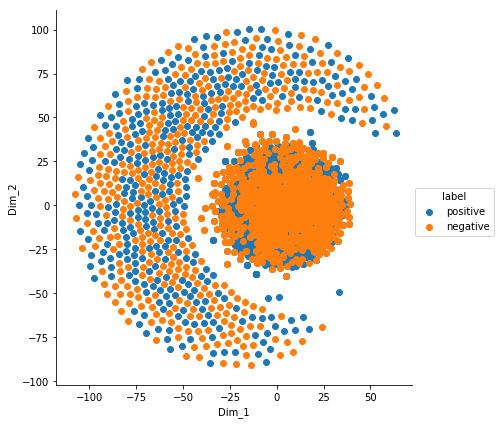

In [143]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [146]:
# t_SNE with perplixity=50 and n_tier=2000

from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2,perplexity=50,n_iter=2000, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne


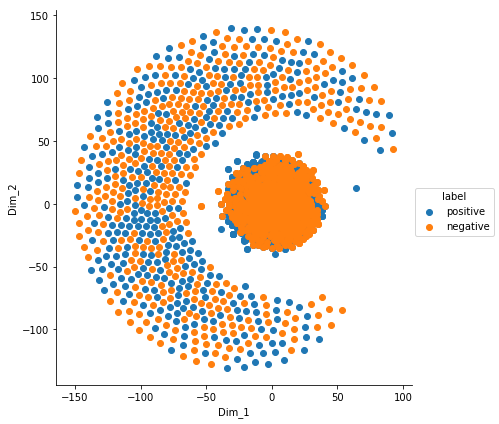

In [147]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Bi-Grams and n-Grams

In [61]:
# Frequence Distribution of words

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))


Most Common Positive Words :  [(b'food', 1471), (b'dog', 1362), (b'cat', 1111), (b'not', 995), (b'one', 978), (b'trap', 949), (b'love', 883), (b'use', 831), (b'get', 777), (b'like', 769), (b'treat', 639), (b'great', 600), (b'well', 554), (b'product', 542), (b'good', 541), (b'mole', 502), (b'tri', 495), (b'year', 491), (b'time', 456), (b'day', 450)]
Most Common Negative Words :  [(b'not', 1793), (b'product', 911), (b'like', 844), (b'tast', 792), (b'one', 708), (b'food', 600), (b'would', 593), (b'use', 591), (b'get', 521), (b'tri', 514), (b'order', 500), (b'good', 496), (b'buy', 460), (b'flavor', 416), (b'dog', 404), (b'dont', 400), (b'time', 397), (b'look', 394), (b'coffe', 391), (b'even', 385)]


In [62]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_postive_negative['Text'].values)

In [63]:
# Biagram Counts
final_bigram_counts.get_shape()

(4000, 158520)

# TI-IDF

In [63]:
# TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_postive_negative['Text'].values)

In [64]:
final_tf_idf

<4000x158520 sparse matrix of type '<class 'numpy.float64'>'
	with 570778 stored elements in Compressed Sparse Row format>

In [65]:
final_tf_idf.get_shape()

(4000, 158520)

In [66]:
features = tf_idf_vect.get_feature_names()
len(features)

158520

In [67]:
features[100000:100020]

['parmigiano romano',
 'parrots',
 'parrots in',
 'parsing',
 'parsing it',
 'parsley',
 'parsley and',
 'parsley flavored',
 'parson',
 'parson russell',
 'part',
 'part about',
 'part and',
 'part as',
 'part at',
 'part being',
 'part br',
 'part dog',
 'part in',
 'part is']

In [72]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[0:,0:10000].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [73]:
final_tf_idf[0:,0:10000].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
final_tf_idf.shape

(4000, 158520)

In [47]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [48]:
top_tfidf

feature     tfidf
0           two hands  0.142905
1         rosie movie  0.142905
2            hands to  0.142905
3        incorporates  0.142905
4        sendak books  0.142905
5       reading these  0.142905
6   incorporates them  0.142905
7      the paperbacks  0.142905
8          pages open  0.142905
9   that incorporates  0.142905
10      cover version  0.142905
11          takes two  0.142905
12       however miss  0.142905
13         paperbacks  0.142905
14    paperbacks seem  0.142905
15         up reading  0.142905
16          seem kind  0.142905
17       these sendak  0.142905
18          of flimsy  0.142905
19         hard cover  0.142905
20         do however  0.136168
21        version the  0.136168
22       watching the  0.136168
23          son loves  0.136168
24          the pages  0.136168

# t-SNE for TF-IDF

In [77]:
# Data-preprocessing: Standardizing the data
#Note: Got memory error when tried to Standardize.Beucase of huge data,System got hanged.Therefore,tried to plot t-SNE with (4000,20000)
from sklearn.preprocessing import StandardScaler

# Converter to toarry()
standardized_data = StandardScaler(with_mean='False').fit_transform(final_tf_idf[0:,0:20000].toarray())
print(standardized_data.shape)

(4000, 20000)


In [78]:
# Building t-SNE for TF-IDF
from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))


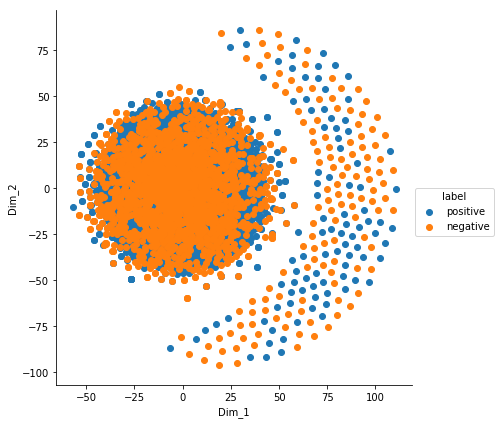

In [79]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Word2Vec

In [35]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_postive_negative['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
                #str1=b"".join(filtered_sentence)
        list_of_sent.append(filtered_sentence)
                
    

    

In [69]:
print(final_postive_negative['Text'].values[0])


this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [70]:
print(list_of_sent[0])

['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [71]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [72]:
words = list(w2v_model.wv.vocab)
print(len(words))

14738


In [73]:
w2v_model.wv.most_similar('tasty')

[('difficult', 0.575829267501831),
 ('boo', 0.5402368307113647),
 ('piping', 0.5068609714508057),
 ('remotely', 0.50560462474823),
 ('mmm', 0.5021642446517944),
 ('torrone', 0.49328795075416565),
 ('misleading', 0.4871564507484436),
 ('doesnt', 0.47259142994880676),
 ('metallic', 0.46673810482025146),
 ('lactose', 0.46392950415611267)]

In [74]:
w2v_model.wv.most_similar('like')

[('raspberry', 0.5303077101707458),
 ('attracts', 0.5113332271575928),
 ('daylight', 0.5045952200889587),
 ('seasonal', 0.5000060796737671),
 ('with', 0.4816969633102417),
 ('strawberry', 0.4764094948768616),
 ('shaping', 0.45914846658706665),
 ('spots', 0.45126351714134216),
 ('have', 0.44886845350265503),
 ('kills', 0.4483222961425781)]

In [75]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
count_vect_feat.index('like')
print(count_vect_feat[64055])

homework


In [33]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_postive_negative['CleanedText'].values:
    list_of_sent.append(sent.split())

In [30]:
print(final_postive_negative['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'
*****************************************************************
[b'witti', b'littl', b'book', b'make', b'son', b'laugh', b'loud', b'recit', b'car', b'drive', b'along', b'alway', b'sing', b'refrain', b'hes', b'learn', b'whale', b'india', b'droop', b'love', b'new', b'word', b'book', b'introduc', b'silli', b'classic', b'book', b'will', b'bet', b'son', b'still', b'abl', b'recit', b'memori', b'colleg']


In [36]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14738
sample words  ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'love', 'all', 'new', 'words', 'introduces', 'silliness', 'of', 'is', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'still', 'be', 'able']


# Avg W2Vec

In [45]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


  1%|▌                                                                         | 2482/366208 [00:09<1:06:35, 91.02it/s]


  2%|█▏                                                                         | 5682/366208 [00:18<14:27, 415.41it/s]


  2%|█▋                                                                         | 8148/366208 [00:27<54:44, 109.00it/s]


  3%|██▎                                                                       | 11503/366208 [00:36<11:11, 528.11it/s]


  4%|██▉                                                                      | 14432/366208 [00:46<1:07:10, 87.28it/s]


  4%|███                                                                      | 15284/366208 [00:55<2:05:10, 46.73it/s]


  4%|███▏                                                                     | 15804/366208 [01:04<3:28:18, 28.04it/s]


  4%|███▏                                                                     | 16009/366208 [01:12<3:57:27, 24.58it/s]


  4%|███▏                                                                     | 16215/366208 [01:21<3:47:34, 25.63it/s]


  4%|███▎                                                                     | 16420/366208 [01:29<3:56:11, 24.68it/s]


  5%|███▎                                                                     | 16626/366208 [01:37<3:53:19, 24.97it/s]


  5%|███▍                                                                      | 17131/366208 [01:46<50:50, 114.43it/s]


  5%|███▌                                                                      | 17939/366208 [01:54<29:21, 197.70it/s]


  5%|███▊                                                                     | 19306/366208 [02:03<1:36:51, 59.69it/s]


  5%|████                                                                     | 20075/366208 [02:11<1:13:20, 78.65it/s]


  6%|████                                                                     | 20621/366208 [02:21<3:00:40, 31.88it/s]


  6%|████▏                                                                    | 20893/366208 [02:29<2:59:49, 32.00it/s]


  6%|████▎                                                                    | 21339/366208 [02:37<1:34:46, 60.64it/s]


  6%|████▍                                                                    | 22201/366208 [02:45<1:45:48, 54.19it/s]


  6%|████▌                                                                    | 22888/366208 [02:53<1:05:59, 86.72it/s]


  6%|████▋                                                                    | 23306/366208 [03:01<1:58:48, 48.10it/s]


  7%|████▊                                                                    | 24405/366208 [03:10<1:04:37, 88.15it/s]


  7%|█████▎                                                                    | 26226/366208 [03:18<22:08, 255.93it/s]


  7%|█████▎                                                                   | 26872/366208 [03:29<2:12:45, 42.60it/s]


  7%|█████▍                                                                   | 27277/366208 [03:36<1:42:44, 54.98it/s]


  8%|█████▊                                                                    | 28744/366208 [03:45<36:07, 155.71it/s]


  8%|██████▏                                                                   | 30766/366208 [03:54<22:13, 251.58it/s]


  9%|██████▍                                                                   | 32115/366208 [04:03<42:50, 129.98it/s]


  9%|██████▊                                                                   | 33625/366208 [04:12<21:13, 261.13it/s]


 10%|███████                                                                   | 34790/366208 [04:21<41:08, 134.27it/s]


 10%|██████▉                                                                  | 35115/366208 [04:30<3:24:31, 26.98it/s]


 10%|███████                                                                  | 35330/366208 [04:38<3:29:19, 26.35it/s]


 10%|███████                                                                  | 35543/366208 [04:46<3:24:58, 26.89it/s]


 10%|███████▎                                                                  | 36254/366208 [04:54<25:40, 214.15it/s]


 10%|███████▌                                                                  | 37211/366208 [05:02<51:33, 106.33it/s]


 10%|███████▊                                                                   | 37890/366208 [05:10<59:26, 92.06it/s]


 11%|███████▋                                                                 | 38821/366208 [05:19<1:28:04, 61.95it/s]


 11%|███████▊                                                                 | 39233/366208 [05:32<7:36:04, 11.95it/s]


 11%|███████▊                                                                 | 39369/366208 [05:43<7:19:09, 12.40it/s]


 11%|███████▊                                                                 | 39505/366208 [05:55<7:31:39, 12.06it/s]


 11%|███████▉                                                                 | 39641/366208 [06:06<7:15:33, 12.50it/s]


 11%|███████▉                                                                 | 39777/366208 [06:17<7:23:43, 12.26it/s]


 11%|███████▉                                                                 | 39913/366208 [06:28<8:13:39, 11.02it/s]


 11%|███████▉                                                                 | 40049/366208 [06:39<7:39:28, 11.83it/s]


 11%|████████                                                                 | 40185/366208 [06:50<7:26:19, 12.17it/s]


 11%|████████                                                                 | 40321/366208 [07:02<7:13:26, 12.53it/s]


 11%|████████                                                                 | 40457/366208 [07:13<7:17:07, 12.42it/s]


 11%|████████                                                                 | 40593/366208 [07:24<7:30:25, 12.05it/s]


 11%|████████                                                                 | 40729/366208 [07:35<7:11:09, 12.58it/s]


 11%|████████▏                                                                | 40865/366208 [07:46<8:21:28, 10.81it/s]


 11%|████████▍                                                                 | 41519/366208 [07:55<51:47, 104.48it/s]


 11%|████████▎                                                                | 42012/366208 [08:03<2:07:32, 42.36it/s]


 12%|████████▍                                                                | 42413/366208 [08:11<1:25:59, 62.76it/s]


 12%|████████▋                                                                 | 43225/366208 [08:19<47:16, 113.88it/s]


 12%|████████▋                                                                | 43621/366208 [08:27<1:57:47, 45.64it/s]


 12%|████████▊                                                                | 44241/366208 [08:36<1:24:40, 63.38it/s]


 12%|████████▊                                                                | 44460/366208 [08:44<3:22:17, 26.51it/s]


 12%|████████▉                                                                | 44666/366208 [08:52<3:17:15, 27.17it/s]


 12%|████████▉                                                                | 44871/366208 [09:00<3:29:40, 25.54it/s]


 12%|█████████▏                                                                | 45462/366208 [09:08<30:07, 177.47it/s]


 13%|█████████▏                                                               | 46059/366208 [09:18<2:01:25, 43.94it/s]


 13%|█████████▏                                                               | 46391/366208 [09:26<2:20:20, 37.98it/s]


 13%|█████████▎                                                               | 46671/366208 [09:34<2:28:24, 35.89it/s]


 13%|█████████▎                                                               | 47003/366208 [09:42<1:23:55, 63.39it/s]


 13%|█████████▍                                                               | 47426/366208 [09:51<2:21:18, 37.60it/s]


 13%|█████████▋                                                                | 48231/366208 [09:59<48:05, 110.18it/s]


 14%|██████████                                                                | 49632/366208 [10:08<52:21, 100.78it/s]


 14%|██████████▏                                                               | 50496/366208 [10:16<43:50, 120.00it/s]


 14%|██████████▏                                                              | 50820/366208 [10:24<2:18:04, 38.07it/s]


 14%|██████████▍                                                               | 51578/366208 [10:32<44:44, 117.19it/s]


 14%|██████████▌                                                               | 52491/366208 [10:40<26:50, 194.74it/s]


 15%|██████████▋                                                              | 53492/366208 [10:50<2:00:57, 43.09it/s]


 15%|██████████▋                                                              | 53832/366208 [10:58<2:25:13, 35.85it/s]


 15%|██████████▊                                                              | 54097/366208 [11:06<2:51:21, 30.36it/s]


 15%|██████████▊                                                              | 54330/366208 [11:14<2:49:54, 30.59it/s]


 15%|███████████                                                               | 54798/366208 [11:22<31:57, 162.44it/s]


 15%|███████████▏                                                             | 55914/366208 [11:31<1:16:10, 67.89it/s]


 16%|███████████▎                                                             | 56864/366208 [11:40<1:22:51, 62.23it/s]


 16%|███████████▍                                                             | 57626/366208 [11:48<1:16:36, 67.13it/s]


 16%|███████████▊                                                             | 59077/366208 [11:56<1:00:05, 85.18it/s]


 17%|████████████▏                                                             | 60525/366208 [12:05<30:38, 166.24it/s]


 17%|████████████▌                                                             | 61939/366208 [12:15<22:51, 221.84it/s]


 17%|████████████▊                                                             | 63178/366208 [12:24<34:12, 147.62it/s]


 18%|█████████████▏                                                             | 64527/366208 [12:33<54:22, 92.47it/s]


 18%|████████████▉                                                            | 64754/366208 [12:43<4:05:30, 20.46it/s]


 18%|████████████▉                                                            | 64958/366208 [12:53<3:51:49, 21.66it/s]


 18%|████████████▉                                                            | 65162/366208 [13:02<3:51:04, 21.71it/s]


 18%|█████████████                                                            | 65460/366208 [13:11<1:02:47, 79.83it/s]


 18%|█████████████▌                                                            | 66911/366208 [13:20<40:49, 122.17it/s]


 19%|█████████████▉                                                            | 68788/366208 [13:28<23:50, 207.95it/s]


 19%|██████████████                                                           | 70237/366208 [13:37<1:11:30, 68.98it/s]


 20%|██████████████▊                                                            | 72107/366208 [13:47<50:18, 97.42it/s]


 20%|██████████████▊                                                           | 73246/366208 [13:55<33:39, 145.06it/s]


 20%|███████████████                                                           | 74549/366208 [14:04<25:41, 189.25it/s]


 21%|███████████████▍                                                          | 76500/366208 [14:13<17:48, 271.06it/s]


 21%|███████████████▊                                                          | 78259/366208 [14:22<45:38, 105.14it/s]


 22%|████████████████                                                          | 79412/366208 [14:31<29:52, 160.00it/s]


 22%|████████████████▎                                                         | 81006/366208 [14:39<16:10, 294.00it/s]


 22%|████████████████▋                                                         | 82347/366208 [14:48<20:40, 228.84it/s]


 23%|████████████████▊                                                         | 83425/366208 [14:57<31:31, 149.50it/s]


 23%|█████████████████▏                                                        | 85106/366208 [15:06<29:13, 160.30it/s]


 23%|█████████████████                                                        | 85808/366208 [15:15<1:56:19, 40.17it/s]


 24%|█████████████████▋                                                         | 86478/366208 [15:23<51:15, 90.94it/s]


 24%|█████████████████▎                                                       | 86791/366208 [15:32<3:19:37, 23.33it/s]


 24%|█████████████████▎                                                       | 86995/366208 [15:41<3:29:29, 22.21it/s]


 24%|█████████████████▍                                                       | 87357/366208 [15:50<1:26:19, 53.83it/s]


 24%|█████████████████▌                                                       | 88073/366208 [16:01<2:52:17, 26.91it/s]


 24%|█████████████████▌                                                       | 88350/366208 [16:09<1:22:15, 56.30it/s]


 24%|█████████████████▋                                                       | 88759/366208 [16:18<1:42:15, 45.22it/s]


 24%|██████████████████▎                                                        | 89150/366208 [16:25<49:02, 94.15it/s]


 25%|█████████████████▉                                                       | 90104/366208 [16:34<2:16:33, 33.70it/s]


 25%|██████████████████                                                       | 90380/366208 [16:43<2:20:03, 32.82it/s]


 25%|██████████████████▋                                                        | 91525/366208 [16:51<46:46, 97.87it/s]


 25%|██████████████████▋                                                       | 92307/366208 [16:59<34:57, 130.59it/s]


 25%|███████████████████                                                        | 93140/366208 [17:07<50:03, 90.91it/s]


 26%|███████████████████▎                                                       | 94502/366208 [17:16<50:05, 90.41it/s]


 26%|██████████████████▉                                                      | 94977/366208 [17:24<1:18:42, 57.43it/s]


 26%|███████████████████▌                                                      | 96629/366208 [17:32<33:22, 134.61it/s]


 27%|███████████████████▊                                                      | 97885/366208 [17:40<29:44, 150.38it/s]


 27%|████████████████████                                                      | 99051/366208 [17:49<19:30, 228.17it/s]


 27%|████████████████████                                                     | 100526/366208 [17:58<31:00, 142.80it/s]


 28%|████████████████████▌                                                     | 101818/366208 [18:07<49:20, 89.31it/s]


 28%|████████████████████▋                                                    | 103639/366208 [18:15<18:25, 237.60it/s]


 29%|█████████████████████                                                    | 105432/366208 [18:23<13:06, 331.77it/s]


 29%|█████████████████████▋                                                    | 107225/366208 [18:33<59:13, 72.88it/s]


 29%|█████████████████████▏                                                  | 107727/366208 [18:40<1:23:57, 51.31it/s]


 30%|█████████████████████▋                                                   | 108502/366208 [18:49<23:11, 185.21it/s]


 30%|██████████████████████                                                    | 109412/366208 [18:57<43:15, 98.95it/s]


 30%|█████████████████████▉                                                   | 110241/366208 [19:06<26:03, 163.68it/s]


 30%|██████████████████████▍                                                   | 111224/366208 [19:14<53:49, 78.96it/s]


 31%|██████████████████████▎                                                  | 112214/366208 [19:22<18:39, 226.85it/s]


 31%|██████████████████████▋                                                  | 113787/366208 [19:31<37:30, 112.17it/s]


 31%|██████████████████████▌                                                 | 114728/366208 [19:43<3:08:44, 22.21it/s]


 31%|██████████████████████▌                                                 | 114912/366208 [19:52<3:19:48, 20.96it/s]


 31%|██████████████████████▋                                                 | 115111/366208 [20:02<3:22:10, 20.70it/s]


 31%|██████████████████████▋                                                 | 115277/366208 [20:11<3:49:43, 18.21it/s]


 32%|███████████████████████                                                  | 115912/366208 [20:19<29:37, 140.80it/s]


 32%|██████████████████████▉                                                 | 116787/366208 [20:28<1:14:41, 55.66it/s]


 32%|███████████████████████▊                                                  | 117753/366208 [20:36<52:18, 79.15it/s]


 32%|███████████████████████▋                                                 | 118799/366208 [20:44<24:16, 169.88it/s]


 33%|███████████████████████▉                                                 | 119822/366208 [20:53<29:02, 141.36it/s]


 33%|████████████████████████                                                 | 120670/366208 [21:01<28:26, 143.85it/s]


 33%|███████████████████████▉                                                | 121616/366208 [21:11<1:53:16, 35.99it/s]


 33%|███████████████████████▉                                                | 121898/366208 [21:18<1:55:59, 35.10it/s]


 33%|████████████████████████▋                                                 | 122373/366208 [21:26<47:07, 86.24it/s]


 33%|████████████████████████                                                | 122633/366208 [21:38<5:01:33, 13.46it/s]


 34%|████████████████████████▏                                               | 122769/366208 [21:48<4:55:51, 13.71it/s]


 34%|████████████████████████▏                                               | 122905/366208 [21:59<5:06:51, 13.21it/s]


 34%|████████████████████████▏                                               | 123041/366208 [22:09<5:14:24, 12.89it/s]


 34%|████████████████████████▏                                               | 123177/366208 [22:19<5:32:14, 12.19it/s]


 34%|████████████████████████▏                                               | 123313/366208 [22:29<4:54:51, 13.73it/s]


 34%|████████████████████████▎                                               | 123492/366208 [22:38<2:29:28, 27.06it/s]


 34%|████████████████████████▎                                               | 123707/366208 [22:46<2:32:04, 26.58it/s]


 34%|████████████████████████▎                                               | 123919/366208 [22:54<2:36:47, 25.75it/s]


 34%|█████████████████████████▎                                                | 125141/366208 [23:03<45:10, 88.94it/s]


 34%|████████████████████████▋                                               | 125688/366208 [23:11<2:00:21, 33.30it/s]


 34%|████████████████████████▊                                               | 125961/366208 [23:20<2:07:49, 31.33it/s]


 35%|█████████████████████████▏                                               | 126597/366208 [23:28<27:35, 144.70it/s]


 35%|█████████████████████████▊                                                | 127969/366208 [23:37<59:32, 66.68it/s]


 35%|█████████████████████████▎                                              | 128512/366208 [23:45<1:50:03, 35.99it/s]


 35%|█████████████████████████▎                                              | 128797/366208 [23:53<2:03:51, 31.95it/s]


 35%|██████████████████████████                                                | 129251/366208 [24:01<54:33, 72.38it/s]


 36%|██████████████████████████▎                                               | 130440/366208 [24:10<50:04, 78.47it/s]


 36%|█████████████████████████▋                                              | 130904/366208 [24:19<1:26:01, 45.59it/s]


 36%|██████████████████████████▎                                              | 131777/366208 [24:26<29:40, 131.65it/s]


 36%|██████████████████████████                                              | 132600/366208 [24:35<1:23:21, 46.71it/s]


 36%|██████████████████████████▉                                               | 133496/366208 [24:43<42:18, 91.67it/s]


 37%|██████████████████████████▎                                             | 133873/366208 [24:52<1:32:52, 41.69it/s]


 37%|██████████████████████████▍                                             | 134197/366208 [25:00<2:13:03, 29.06it/s]


 37%|██████████████████████████▍                                             | 134451/366208 [25:09<2:13:04, 29.02it/s]


 37%|██████████████████████████▍                                             | 134707/366208 [25:17<2:41:28, 23.89it/s]


 37%|██████████████████████████▌                                             | 134911/366208 [25:26<2:50:05, 22.67it/s]


 37%|██████████████████████████▌                                             | 135115/366208 [25:35<2:49:40, 22.70it/s]


 37%|██████████████████████████▌                                             | 135319/366208 [25:43<2:43:41, 23.51it/s]


 37%|███████████████████████████                                              | 135636/366208 [25:52<36:25, 105.49it/s]


 37%|███████████████████████████▏                                             | 136354/366208 [26:01<23:57, 159.88it/s]


 37%|██████████████████████████▉                                             | 137128/366208 [26:09<1:01:13, 62.37it/s]


 38%|███████████████████████████                                             | 137735/366208 [26:18<1:31:06, 41.79it/s]


 38%|███████████████████████████▏                                            | 138192/366208 [26:26<1:21:18, 46.74it/s]


 38%|████████████████████████████                                              | 138635/366208 [26:34<38:45, 97.88it/s]


 38%|███████████████████████████▎                                            | 139182/366208 [26:43<1:10:08, 53.95it/s]


 38%|███████████████████████████▊                                             | 139813/366208 [26:52<26:50, 140.61it/s]


 38%|████████████████████████████▍                                             | 140544/366208 [26:59<57:26, 65.48it/s]


 39%|███████████████████████████▊                                            | 141422/366208 [27:08<1:08:47, 54.46it/s]


 39%|████████████████████████████▋                                             | 141948/366208 [27:16<57:33, 64.94it/s]


 39%|████████████████████████████▏                                           | 143299/366208 [27:25<1:05:10, 57.00it/s]


 39%|████████████████████████████▋                                            | 143695/366208 [27:33<36:09, 102.58it/s]


 39%|████████████████████████████▎                                           | 144209/366208 [27:44<2:02:56, 30.10it/s]


 40%|████████████████████████████▊                                            | 144815/366208 [27:52<19:22, 190.44it/s]


 40%|████████████████████████████▌                                           | 145353/366208 [28:01<1:52:55, 32.60it/s]


 40%|████████████████████████████▋                                           | 145625/366208 [28:09<1:52:44, 32.61it/s]


 40%|████████████████████████████▋                                           | 146029/366208 [28:18<1:24:23, 43.48it/s]


 40%|█████████████████████████████▌                                            | 146435/366208 [28:26<58:02, 63.11it/s]


 40%|████████████████████████████▉                                           | 147070/366208 [28:36<3:41:35, 16.48it/s]


 40%|████████████████████████████▉                                           | 147206/366208 [28:44<3:42:17, 16.42it/s]


 40%|████████████████████████████▉                                           | 147342/366208 [28:53<3:39:25, 16.62it/s]


 40%|████████████████████████████▉                                           | 147478/366208 [29:01<3:35:12, 16.94it/s]


 40%|█████████████████████████████                                           | 147614/366208 [29:09<3:38:35, 16.67it/s]


 40%|█████████████████████████████                                           | 147750/366208 [29:18<3:33:24, 17.06it/s]


 40%|█████████████████████████████▉                                            | 148076/366208 [29:26<55:46, 65.18it/s]


 41%|█████████████████████████████▋                                           | 148939/366208 [29:34<30:22, 119.25it/s]


 41%|█████████████████████████████▍                                          | 149602/366208 [29:43<2:33:24, 23.53it/s]


 41%|█████████████████████████████▍                                          | 149790/366208 [29:52<2:33:53, 23.44it/s]


 41%|█████████████████████████████▍                                          | 149996/366208 [30:00<2:24:59, 24.85it/s]


 41%|██████████████████████████████▍                                           | 150403/366208 [30:08<39:58, 89.97it/s]


 41%|██████████████████████████████▌                                           | 150950/366208 [30:16<49:29, 72.48it/s]


 41%|█████████████████████████████▊                                          | 151658/366208 [30:24<1:27:44, 40.75it/s]


 41%|█████████████████████████████▉                                          | 151972/366208 [30:32<2:56:41, 20.21it/s]


 42%|█████████████████████████████▉                                          | 152128/366208 [30:41<3:19:26, 17.89it/s]


 42%|█████████████████████████████▉                                          | 152274/366208 [30:48<3:12:08, 18.56it/s]


 42%|█████████████████████████████▉                                          | 152429/366208 [30:56<3:27:33, 17.17it/s]


 42%|██████████████████████████████                                          | 152603/366208 [31:05<3:16:12, 18.14it/s]


 42%|██████████████████████████████                                          | 152764/366208 [31:14<3:05:33, 19.17it/s]


 42%|██████████████████████████████▉                                           | 153071/366208 [31:23<53:59, 65.78it/s]


 42%|██████████████████████████████▏                                         | 153393/366208 [31:33<4:49:10, 12.27it/s]


 42%|██████████████████████████████▏                                         | 153538/366208 [31:43<3:24:16, 17.35it/s]


 42%|██████████████████████████████▏                                         | 153705/366208 [31:53<3:04:00, 19.25it/s]


 42%|██████████████████████████████▎                                         | 153943/366208 [32:02<1:11:26, 49.52it/s]


 42%|██████████████████████████████▎                                         | 154285/366208 [32:10<1:17:15, 45.72it/s]


 42%|██████████████████████████████▍                                         | 154575/366208 [32:18<2:07:41, 27.62it/s]


 42%|██████████████████████████████▍                                         | 154844/366208 [32:27<1:52:23, 31.34it/s]


 42%|██████████████████████████████▉                                          | 155495/366208 [32:35<29:35, 118.69it/s]


 43%|███████████████████████████████▋                                          | 157012/366208 [32:44<40:40, 85.73it/s]


 43%|███████████████████████████████▉                                          | 158078/366208 [32:52<36:44, 94.41it/s]


 44%|███████████████████████████████▊                                         | 159390/366208 [33:01<17:45, 194.09it/s]


 44%|████████████████████████████████▍                                         | 160708/366208 [33:10<34:52, 98.20it/s]


 44%|███████████████████████████████▋                                        | 161336/366208 [33:18<1:08:24, 49.91it/s]


 44%|████████████████████████████████▍                                        | 162533/366208 [33:26<14:56, 227.22it/s]


 45%|████████████████████████████████▋                                        | 164223/366208 [33:35<14:11, 237.07it/s]


 45%|████████████████████████████████▉                                        | 165434/366208 [33:44<26:37, 125.72it/s]


 45%|████████████████████████████████▋                                       | 165976/366208 [33:54<1:51:49, 29.84it/s]


 45%|████████████████████████████████▋                                       | 166360/366208 [34:02<1:26:18, 38.59it/s]


 46%|█████████████████████████████████▋                                        | 166734/366208 [34:10<37:21, 89.00it/s]


 46%|█████████████████████████████████▌                                       | 168657/366208 [34:19<31:41, 103.90it/s]


 46%|█████████████████████████████████▊                                       | 169855/366208 [34:27<11:41, 279.83it/s]


 47%|█████████████████████████████████▉                                       | 170353/366208 [34:37<30:13, 107.98it/s]


 47%|██████████████████████████████████▋                                       | 171843/366208 [34:46<50:47, 63.78it/s]


 47%|██████████████████████████████████▊                                       | 172548/366208 [34:54<39:04, 82.59it/s]


 47%|███████████████████████████████████                                       | 173309/366208 [35:03<58:20, 55.11it/s]


 47%|██████████████████████████████████▏                                     | 173690/366208 [35:11<2:02:11, 26.26it/s]


 47%|██████████████████████████████████▏                                     | 173894/366208 [35:19<2:33:20, 20.90it/s]


 48%|██████████████████████████████████▏                                     | 174098/366208 [35:27<1:57:58, 27.14it/s]


 48%|██████████████████████████████████▉                                      | 175153/366208 [35:35<25:55, 122.81it/s]


 48%|██████████████████████████████████▌                                     | 175948/366208 [35:44<1:05:31, 48.39it/s]


 48%|███████████████████████████████████▍                                     | 177601/366208 [35:53<17:05, 183.95it/s]


 49%|████████████████████████████████████                                      | 178489/366208 [36:03<36:57, 84.64it/s]


 49%|███████████████████████████████████▎                                    | 179338/366208 [36:13<1:14:37, 41.73it/s]


 49%|███████████████████████████████████▉                                     | 180593/366208 [36:21<13:32, 228.31it/s]


 50%|████████████████████████████████████▋                                     | 181792/366208 [36:31<44:36, 68.90it/s]


 50%|███████████████████████████████████▊                                    | 182284/366208 [36:40<1:57:34, 26.07it/s]


 50%|███████████████████████████████████▉                                    | 182488/366208 [36:48<1:55:39, 26.47it/s]


 50%|████████████████████████████████████▉                                     | 182886/366208 [36:56<42:33, 71.78it/s]


 50%|████████████████████████████████████▌                                    | 183488/366208 [37:04<22:58, 132.55it/s]


 50%|████████████████████████████████████▊                                    | 184622/366208 [37:14<18:34, 162.96it/s]


 51%|█████████████████████████████████████▏                                   | 186309/366208 [37:23<11:35, 258.54it/s]


 51%|████████████████████████████████████▊                                   | 187488/366208 [37:33<1:59:08, 25.00it/s]


 51%|████████████████████████████████████▉                                   | 187707/366208 [37:41<1:56:51, 25.46it/s]


 51%|████████████████████████████████████▉                                   | 187914/366208 [37:50<2:44:33, 18.06it/s]


 51%|████████████████████████████████████▉                                   | 188128/366208 [37:59<1:02:20, 47.60it/s]


 52%|█████████████████████████████████████▉                                   | 190315/366208 [38:08<12:26, 235.49it/s]


 52%|██████████████████████████████████████▋                                   | 191413/366208 [38:17<29:16, 99.52it/s]


 53%|██████████████████████████████████████▍                                  | 192722/366208 [38:27<18:03, 160.09it/s]


 53%|██████████████████████████████████████                                  | 193644/366208 [38:40<2:05:17, 22.95it/s]


 53%|███████████████████████████████████████▏                                  | 193875/366208 [38:49<51:43, 55.52it/s]


 53%|██████████████████████████████████████▊                                  | 194715/366208 [38:58<12:42, 224.80it/s]


 54%|███████████████████████████████████████▏                                 | 196553/366208 [39:07<18:36, 152.01it/s]


 54%|███████████████████████████████████████▉                                  | 197480/366208 [39:15<42:50, 65.64it/s]


 54%|████████████████████████████████████████                                  | 198159/366208 [39:24<42:03, 66.58it/s]


 55%|████████████████████████████████████████▎                                 | 199729/366208 [39:34<56:40, 48.95it/s]


 55%|████████████████████████████████████████▌                                 | 200799/366208 [39:43<46:46, 58.94it/s]


 55%|████████████████████████████████████████▋                                 | 201612/366208 [39:52<43:52, 62.52it/s]


 55%|████████████████████████████████████████▉                                 | 202618/366208 [40:01<59:30, 45.82it/s]


 56%|████████████████████████████████████████                                | 203968/366208 [40:12<2:00:37, 22.42it/s]


 56%|████████████████████████████████████████▏                               | 204161/366208 [40:22<2:09:08, 20.91it/s]


 56%|█████████████████████████████████████████▎                                | 204465/366208 [40:32<27:22, 98.48it/s]


 56%|████████████████████████████████████████▉                                | 205436/366208 [40:41<10:39, 251.37it/s]


 57%|█████████████████████████████████████████▎                               | 207097/366208 [40:50<18:22, 144.26it/s]


 57%|██████████████████████████████████████████                                | 207916/366208 [41:00<28:15, 93.35it/s]


 57%|██████████████████████████████████████████▏                               | 208726/366208 [41:08<57:03, 46.00it/s]


 57%|█████████████████████████████████████████                               | 208998/366208 [41:17<1:17:53, 33.64it/s]


 57%|█████████████████████████████████████████▏                              | 209564/366208 [41:33<3:15:41, 13.34it/s]


 57%|█████████████████████████████████████████▏                              | 209700/366208 [41:41<2:23:14, 18.21it/s]


 57%|█████████████████████████████████████████▎                              | 209833/366208 [41:52<3:26:30, 12.62it/s]


 57%|█████████████████████████████████████████▎                              | 209969/366208 [42:01<2:28:09, 17.58it/s]


 57%|█████████████████████████████████████████▎                              | 210105/366208 [42:08<2:24:06, 18.05it/s]


 57%|█████████████████████████████████████████▎                              | 210241/366208 [42:16<2:30:11, 17.31it/s]


 57%|█████████████████████████████████████████▍                              | 210541/366208 [42:26<3:09:20, 13.70it/s]


 58%|█████████████████████████████████████████▍                              | 210677/366208 [42:34<2:32:43, 16.97it/s]


 58%|█████████████████████████████████████████▍                              | 210813/366208 [42:42<2:42:17, 15.96it/s]


 58%|█████████████████████████████████████████▍                              | 210949/366208 [42:51<2:37:02, 16.48it/s]


 58%|█████████████████████████████████████████▌                              | 211085/366208 [42:59<2:39:30, 16.21it/s]


 58%|█████████████████████████████████████████▌                              | 211346/366208 [43:08<1:24:28, 30.55it/s]


 58%|██████████████████████████████████████████▏                              | 211793/366208 [43:16<24:19, 105.82it/s]


 58%|██████████████████████████████████████████▉                               | 212398/366208 [43:24<39:30, 64.88it/s]


 58%|██████████████████████████████████████████▍                              | 212957/366208 [43:32<23:02, 110.88it/s]


 58%|█████████████████████████████████████████▉                              | 213203/366208 [43:41<1:41:29, 25.13it/s]


 58%|█████████████████████████████████████████▉                              | 213402/366208 [43:50<1:42:53, 24.75it/s]


 58%|██████████████████████████████████████████▋                              | 214083/366208 [43:57<24:24, 103.90it/s]


 59%|███████████████████████████████████████████▍                              | 214725/366208 [44:05<26:22, 95.74it/s]


 59%|███████████████████████████████████████████▌                              | 215682/366208 [44:13<40:56, 61.29it/s]


 59%|███████████████████████████████████████████▊                              | 216881/366208 [44:22<35:36, 69.89it/s]


 59%|████████████████████████████████████████████                              | 217839/366208 [44:30<37:31, 65.91it/s]


 60%|██████████████████████████████████████████▉                             | 218225/366208 [44:39<1:50:42, 22.28it/s]


 60%|██████████████████████████████████████████▉                             | 218429/366208 [44:49<1:55:11, 21.38it/s]


 60%|██████████████████████████████████████████▉                             | 218631/366208 [44:58<1:53:23, 21.69it/s]


 60%|████████████████████████████████████████████▏                             | 218888/366208 [45:08<29:56, 82.01it/s]


 60%|███████████████████████████████████████████▊                             | 219594/366208 [45:15<22:46, 107.32it/s]


 60%|███████████████████████████████████████████▏                            | 219932/366208 [45:25<2:17:17, 17.76it/s]


 60%|███████████████████████████████████████████▎                            | 220070/366208 [45:32<2:14:48, 18.07it/s]


 60%|███████████████████████████████████████████▎                            | 220207/366208 [45:40<2:14:00, 18.16it/s]


 60%|████████████████████████████████████████████▌                             | 220462/366208 [45:49<26:23, 92.03it/s]


 60%|████████████████████████████████████████████▋                             | 221117/366208 [45:58<24:37, 98.22it/s]


 60%|███████████████████████████████████████████▌                            | 221427/366208 [46:06<1:06:30, 36.28it/s]


 61%|███████████████████████████████████████████▌                            | 221637/366208 [46:14<1:31:47, 26.25it/s]


 61%|███████████████████████████████████████████▌                            | 221841/366208 [46:22<1:29:09, 26.99it/s]


 61%|████████████████████████████████████████████▉                             | 222526/366208 [46:30<40:29, 59.14it/s]


 61%|█████████████████████████████████████████████                             | 223265/366208 [46:37<39:27, 60.38it/s]


 61%|█████████████████████████████████████████████▏                            | 223823/366208 [46:46<45:29, 52.17it/s]


 61%|█████████████████████████████████████████████▎                            | 224180/366208 [46:54<34:04, 69.47it/s]


 61%|█████████████████████████████████████████████▎                            | 224547/366208 [47:02<52:45, 44.76it/s]


 61%|████████████████████████████████████████████▏                           | 224763/366208 [47:10<1:26:28, 27.26it/s]


 61%|████████████████████████████████████████████▏                           | 224967/366208 [47:18<1:30:52, 25.91it/s]


 62%|████████████████████████████████████████████▉                            | 225582/366208 [47:26<23:01, 101.78it/s]


 62%|████████████████████████████████████████████▍                           | 226140/366208 [47:37<1:30:10, 25.89it/s]


 62%|█████████████████████████████████████████████▏                           | 226945/366208 [47:45<19:25, 119.45it/s]


 62%|██████████████████████████████████████████████                            | 227694/366208 [47:54<40:44, 56.67it/s]


 62%|████████████████████████████████████████████▊                           | 227945/366208 [48:05<3:27:30, 11.11it/s]


 62%|████████████████████████████████████████████▊                           | 228079/366208 [48:18<4:03:23,  9.46it/s]


 62%|████████████████████████████████████████████▊                           | 228214/366208 [48:30<3:25:18, 11.20it/s]


 62%|████████████████████████████████████████████▉                           | 228349/366208 [48:42<3:23:03, 11.31it/s]


 62%|████████████████████████████████████████████▉                           | 228484/366208 [48:54<3:37:31, 10.55it/s]


 62%|██████████████████████████████████████████████▏                           | 228803/366208 [49:04<30:06, 76.07it/s]


 63%|█████████████████████████████████████████████                           | 229310/366208 [49:13<1:41:51, 22.40it/s]


 63%|█████████████████████████████████████████████                           | 229514/366208 [49:22<1:41:44, 22.39it/s]


 63%|█████████████████████████████████████████████▏                          | 229697/366208 [49:32<4:02:30,  9.38it/s]


 63%|█████████████████████████████████████████████▉                           | 230311/366208 [49:41<21:29, 105.43it/s]


 63%|██████████████████████████████████████████████▋                           | 230942/366208 [49:49<35:20, 63.78it/s]


 63%|██████████████████████████████████████████████▋                           | 231335/366208 [49:58<57:46, 38.91it/s]


 63%|█████████████████████████████████████████████▌                          | 231610/366208 [50:06<1:02:57, 35.64it/s]


 64%|██████████████████████████████████████████████▍                          | 232645/366208 [50:15<17:28, 127.40it/s]


 64%|███████████████████████████████████████████████▏                          | 233477/366208 [50:23<38:41, 57.17it/s]


 64%|██████████████████████████████████████████████                          | 234326/366208 [50:34<1:19:15, 27.73it/s]


 64%|██████████████████████████████████████████████                          | 234531/366208 [50:41<1:17:47, 28.21it/s]


 64%|███████████████████████████████████████████████▌                          | 235109/366208 [50:50<40:55, 53.38it/s]


 64%|██████████████████████████████████████████████▎                         | 235742/366208 [50:59<1:04:02, 33.96it/s]


 64%|██████████████████████████████████████████████▍                         | 236014/366208 [51:07<1:07:07, 32.32it/s]


 65%|███████████████████████████████████████████████▊                          | 236347/366208 [51:14<43:21, 49.92it/s]


 65%|███████████████████████████████████████████████▊                          | 236874/366208 [51:23<40:18, 53.48it/s]


 65%|███████████████████████████████████████████████▉                          | 237424/366208 [51:31<40:23, 53.13it/s]


 65%|███████████████████████████████████████████████▍                         | 238210/366208 [51:39<12:35, 169.49it/s]


 65%|██████████████████████████████████████████████▉                         | 238925/366208 [51:53<1:52:57, 18.78it/s]


 65%|███████████████████████████████████████████████                         | 239067/366208 [52:02<2:04:29, 17.02it/s]


 65%|███████████████████████████████████████████████                         | 239208/366208 [52:11<2:07:05, 16.65it/s]


 65%|███████████████████████████████████████████████                         | 239357/366208 [52:20<2:18:48, 15.23it/s]


 65%|███████████████████████████████████████████████▊                         | 239848/366208 [52:28<14:44, 142.91it/s]


 66%|████████████████████████████████████████████████▌                         | 240518/366208 [52:36<50:05, 41.82it/s]


 66%|████████████████████████████████████████████████▋                         | 241141/366208 [52:46<49:09, 42.40it/s]


 66%|████████████████████████████████████████████████▊                         | 241638/366208 [52:54<59:37, 34.82it/s]


 66%|████████████████████████████████████████████████▉                         | 242065/366208 [53:02<23:39, 87.46it/s]


 66%|█████████████████████████████████████████████████▏                        | 243121/366208 [53:12<33:59, 60.36it/s]


 67%|█████████████████████████████████████████████████▎                        | 243880/366208 [53:22<54:20, 37.52it/s]


 67%|█████████████████████████████████████████████████▍                        | 244506/366208 [53:30<38:52, 52.18it/s]


 67%|█████████████████████████████████████████████████                        | 245815/366208 [53:39<12:39, 158.61it/s]


 67%|█████████████████████████████████████████████████▏                       | 246809/366208 [53:49<08:59, 221.22it/s]


 68%|█████████████████████████████████████████████████▍                       | 247893/366208 [53:59<15:58, 123.45it/s]


 68%|██████████████████████████████████████████████████▏                       | 248521/366208 [54:09<46:38, 42.06it/s]


 68%|██████████████████████████████████████████████████▍                       | 249507/366208 [54:19<43:34, 44.63it/s]


 68%|█████████████████████████████████████████████████▏                      | 250275/366208 [54:29<1:00:12, 32.09it/s]


 68%|██████████████████████████████████████████████████▋                       | 250802/366208 [54:38<40:26, 47.56it/s]


 69%|██████████████████████████████████████████████████▊                       | 251519/366208 [54:49<58:47, 32.51it/s]


 69%|██████████████████████████████████████████████████▎                      | 252299/366208 [54:59<09:29, 200.08it/s]


 69%|███████████████████████████████████████████████████▏                      | 253200/366208 [55:08<49:14, 38.24it/s]


 69%|███████████████████████████████████████████████████▎                      | 253793/366208 [55:17<24:17, 77.11it/s]


 70%|███████████████████████████████████████████████████▍                      | 254599/366208 [55:26<37:40, 49.37it/s]


 70%|███████████████████████████████████████████████████▌                      | 255456/366208 [55:34<29:40, 62.22it/s]


 70%|███████████████████████████████████████████████████                      | 256296/366208 [55:43<17:03, 107.40it/s]


 70%|███████████████████████████████████████████████████▉                      | 256952/366208 [55:53<54:19, 33.52it/s]


 70%|███████████████████████████████████████████████████▉                      | 257217/366208 [56:01<55:11, 32.91it/s]


 70%|████████████████████████████████████████████████████                      | 257928/366208 [56:11<23:10, 77.87it/s]


 71%|████████████████████████████████████████████████████▎                     | 259025/366208 [56:19<23:02, 77.55it/s]


 71%|███████████████████████████████████████████████████▊                     | 260044/366208 [56:29<14:25, 122.64it/s]


 71%|████████████████████████████████████████████████████▋                     | 260843/366208 [56:37<18:35, 94.45it/s]


 72%|████████████████████████████████████████████████████▏                    | 262052/366208 [56:45<07:56, 218.81it/s]


 72%|█████████████████████████████████████████████████████                     | 262711/366208 [56:55<54:07, 31.87it/s]


 72%|███████████████████████████████████████████████████▉                    | 263972/366208 [57:05<1:14:33, 22.85it/s]


 72%|███████████████████████████████████████████████████▉                    | 264168/366208 [57:14<1:13:05, 23.27it/s]


 72%|█████████████████████████████████████████████████████▌                    | 264788/366208 [57:22<19:18, 87.51it/s]


 73%|████████████████████████████████████████████████████▉                    | 265765/366208 [57:31<11:19, 147.88it/s]


 73%|█████████████████████████████████████████████████████▏                   | 266578/366208 [57:39<06:55, 239.74it/s]


 73%|██████████████████████████████████████████████████████                    | 267607/366208 [57:48<26:21, 62.35it/s]


 73%|██████████████████████████████████████████████████████▏                   | 268231/366208 [57:56<27:13, 59.98it/s]


 74%|██████████████████████████████████████████████████████▍                   | 269277/366208 [58:06<47:03, 34.33it/s]


 74%|██████████████████████████████████████████████████████▌                   | 269751/366208 [58:15<29:15, 54.96it/s]


 74%|██████████████████████████████████████████████████████▌                   | 270279/366208 [58:23<15:59, 99.96it/s]


 74%|██████████████████████████████████████████████████████▋                   | 270853/366208 [58:32<31:06, 51.07it/s]


 74%|██████████████████████████████████████████████████████▉                   | 271699/366208 [58:41<50:23, 31.26it/s]


 74%|███████████████████████████████████████████████████████                   | 272653/366208 [58:49<18:17, 85.27it/s]


 75%|███████████████████████████████████████████████████████▏                  | 273277/366208 [58:58<24:57, 62.06it/s]


 75%|██████████████████████████████████████████████████████▌                  | 273944/366208 [59:06<09:54, 155.21it/s]


 75%|█████████████████████████████████████████████████████▉                  | 274298/366208 [59:16<1:28:11, 17.37it/s]


 75%|█████████████████████████████████████████████████████▉                  | 274442/366208 [59:24<1:21:45, 18.71it/s]


 75%|███████████████████████████████████████████████████████▍                  | 274610/366208 [59:33<45:45, 33.36it/s]


 75%|███████████████████████████████████████████████████████▌                  | 274882/366208 [59:41<46:32, 32.70it/s]


 75%|██████████████████████████████████████████████████████                  | 275088/366208 [59:50<1:06:42, 22.76it/s]


 75%|██████████████████████████████████████████████████████                  | 275289/366208 [59:59<1:03:12, 23.98it/s]


 75%|██████████████████████████████████████████████████████▏                 | 275541/366208 [1:00:08<48:49, 30.95it/s]


 75%|████████████████████████████████████████████████████▋                 | 275823/366208 [1:00:17<1:03:41, 23.65it/s]


 75%|████████████████████████████████████████████████████▊                 | 275989/366208 [1:00:26<1:42:28, 14.67it/s]


 75%|████████████████████████████████████████████████████▊                 | 276143/366208 [1:00:36<1:12:13, 20.78it/s]


 75%|████████████████████████████████████████████████████▊                 | 276346/366208 [1:00:46<1:13:21, 20.42it/s]


 76%|██████████████████████████████████████████████████████▍                 | 277098/366208 [1:00:55<28:46, 51.61it/s]


 76%|██████████████████████████████████████████████████████▌                 | 277694/366208 [1:01:04<52:46, 27.95it/s]


 76%|██████████████████████████████████████████████████████▋                 | 277971/366208 [1:01:11<15:15, 96.40it/s]


 76%|██████████████████████████████████████████████████████▊                 | 278564/366208 [1:01:19<19:21, 75.45it/s]


 76%|██████████████████████████████████████████████████████▉                 | 279456/366208 [1:01:29<16:27, 87.85it/s]


 76%|██████████████████████████████████████████████████████▎                | 280107/366208 [1:01:37<07:50, 182.93it/s]


 77%|███████████████████████████████████████████████████████▎                | 281251/366208 [1:01:46<23:15, 60.88it/s]


 77%|███████████████████████████████████████████████████████▌                | 282310/366208 [1:01:55<14:12, 98.38it/s]


 77%|██████████████████████████████████████████████████████▉                | 283406/366208 [1:02:04<11:52, 116.26it/s]


 78%|███████████████████████████████████████████████████████▊                | 284049/366208 [1:02:12<23:50, 57.44it/s]


 78%|███████████████████████████████████████████████████████▏               | 284868/366208 [1:02:20<12:16, 110.40it/s]


 78%|████████████████████████████████████████████████████████▏               | 285825/366208 [1:02:29<19:01, 70.44it/s]


 78%|████████████████████████████████████████████████████████▎               | 286500/366208 [1:02:37<24:30, 54.19it/s]


 78%|███████████████████████████████████████████████████████▋               | 287291/366208 [1:02:46<10:30, 125.14it/s]


 79%|████████████████████████████████████████████████████████▋               | 288045/366208 [1:02:55<21:57, 59.32it/s]


 79%|███████████████████████████████████████████████████████▏              | 289024/366208 [1:03:06<1:06:19, 19.40it/s]


 79%|████████████████████████████████████████████████████████▊               | 289216/366208 [1:03:15<52:17, 24.54it/s]


 79%|████████████████████████████████████████████████████████▉               | 289892/366208 [1:03:24<22:21, 56.91it/s]


 79%|█████████████████████████████████████████████████████████▏              | 290770/366208 [1:03:33<31:52, 39.45it/s]


 79%|███████████████████████████████████████████████████████▌              | 290937/366208 [1:03:42<1:13:00, 17.18it/s]


 79%|███████████████████████████████████████████████████████▋              | 291073/366208 [1:03:51<1:12:48, 17.20it/s]


 80%|███████████████████████████████████████████████████████▋              | 291209/366208 [1:03:58<1:08:44, 18.18it/s]


 80%|█████████████████████████████████████████████████████████▎              | 291555/366208 [1:04:07<37:02, 33.59it/s]


 80%|█████████████████████████████████████████████████████████▍              | 292426/366208 [1:04:17<16:36, 74.03it/s]


 80%|█████████████████████████████████████████████████████████▋              | 293434/366208 [1:04:26<12:46, 94.98it/s]


 80%|█████████████████████████████████████████████████████████              | 294467/366208 [1:04:35<10:38, 112.31it/s]


 81%|█████████████████████████████████████████████████████████▎             | 295424/366208 [1:04:43<08:19, 141.72it/s]


 81%|██████████████████████████████████████████████████████████▏             | 296004/366208 [1:04:51<27:33, 42.45it/s]


 81%|██████████████████████████████████████████████████████████▎             | 296828/366208 [1:05:00<38:52, 29.75it/s]


 81%|██████████████████████████████████████████████████████████▍             | 297069/366208 [1:05:08<38:56, 29.59it/s]


 81%|██████████████████████████████████████████████████████████▌             | 297684/366208 [1:05:17<16:01, 71.28it/s]


 82%|█████████████████████████████████████████████████████████▉             | 298699/366208 [1:05:26<09:46, 115.12it/s]


 82%|██████████████████████████████████████████████████████████▉             | 299774/366208 [1:05:36<27:45, 39.89it/s]


 82%|███████████████████████████████████████████████████████████             | 300397/366208 [1:05:46<26:49, 40.90it/s]


 82%|███████████████████████████████████████████████████████████▎            | 301524/366208 [1:05:56<38:50, 27.76it/s]


 82%|███████████████████████████████████████████████████████████▎            | 301730/366208 [1:06:04<38:41, 27.77it/s]


 83%|███████████████████████████████████████████████████████████▍            | 302315/366208 [1:06:12<21:42, 49.04it/s]


 83%|██████████████████████████████████████████████████████████▊            | 303314/366208 [1:06:20<06:59, 149.93it/s]


 83%|███████████████████████████████████████████████████████████▋            | 303794/366208 [1:06:30<38:04, 27.32it/s]


 83%|███████████████████████████████████████████████████████████▊            | 304001/366208 [1:06:37<36:28, 28.42it/s]


 83%|███████████████████████████████████████████████████████████▊            | 304358/366208 [1:06:48<53:29, 19.27it/s]


 83%|███████████████████████████████████████████████████████████            | 304739/366208 [1:06:56<09:17, 110.33it/s]


 83%|████████████████████████████████████████████████████████████            | 305444/366208 [1:07:05<19:44, 51.32it/s]


 84%|██████████████████████████████████████████████████████████▍           | 305899/366208 [1:07:19<2:29:19,  6.73it/s]


 84%|██████████████████████████████████████████████████████████▍           | 305967/366208 [1:07:29<2:22:44,  7.03it/s]


 84%|██████████████████████████████████████████████████████████▍           | 306035/366208 [1:07:39<2:27:28,  6.80it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306103/366208 [1:07:50<2:26:06,  6.86it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306171/366208 [1:08:00<2:23:29,  6.97it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306239/366208 [1:08:10<2:23:02,  6.99it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306307/366208 [1:08:20<2:26:43,  6.80it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306375/366208 [1:08:30<2:26:42,  6.80it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306443/366208 [1:08:40<2:22:40,  6.98it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306511/366208 [1:08:50<2:22:22,  6.99it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306579/366208 [1:09:00<2:25:07,  6.85it/s]


 84%|██████████████████████████████████████████████████████████▌           | 306647/366208 [1:09:10<2:21:32,  7.01it/s]


 84%|████████████████████████████████████████████████████████████▎           | 306759/366208 [1:09:20<45:20, 21.85it/s]


 84%|████████████████████████████████████████████████████████████▍           | 307323/366208 [1:09:30<54:38, 17.96it/s]


 84%|████████████████████████████████████████████████████████████▌           | 307746/366208 [1:09:40<27:17, 35.70it/s]


 84%|████████████████████████████████████████████████████████████▋           | 308357/366208 [1:09:50<34:03, 28.32it/s]


 84%|████████████████████████████████████████████████████████████▋           | 308565/366208 [1:10:01<43:01, 22.33it/s]


 84%|████████████████████████████████████████████████████████████▊           | 308995/366208 [1:10:11<29:44, 32.07it/s]


 85%|████████████████████████████████████████████████████████████           | 309574/366208 [1:10:18<06:45, 139.54it/s]


 85%|████████████████████████████████████████████████████████████▏          | 310537/366208 [1:10:29<08:12, 112.95it/s]


 85%|█████████████████████████████████████████████████████████████▏          | 311404/366208 [1:10:37<11:25, 79.99it/s]


 85%|████████████████████████████████████████████████████████████▌          | 312309/366208 [1:10:47<04:49, 186.12it/s]


 86%|████████████████████████████████████████████████████████████▋          | 313329/366208 [1:10:55<06:55, 127.40it/s]


 86%|█████████████████████████████████████████████████████████████▊          | 314231/366208 [1:11:04<13:27, 64.39it/s]


 86%|█████████████████████████████████████████████████████████████▉          | 315132/366208 [1:11:13<16:16, 52.31it/s]


 86%|██████████████████████████████████████████████████████████████          | 315556/366208 [1:11:21<19:52, 42.46it/s]


 86%|██████████████████████████████████████████████████████████████          | 315947/366208 [1:11:30<47:56, 17.48it/s]


 86%|██████████████████████████████████████████████████████████████▏         | 316146/366208 [1:11:39<55:23, 15.06it/s]


 86%|██████████████████████████████████████████████████████████████▏         | 316482/366208 [1:11:49<20:17, 40.84it/s]


 87%|█████████████████████████████████████████████████████████████▌         | 317457/366208 [1:11:57<06:31, 124.54it/s]


 87%|██████████████████████████████████████████████████████████████▌         | 318073/366208 [1:12:07<28:19, 28.32it/s]


 87%|██████████████████████████████████████████████████████████████▋         | 318660/366208 [1:12:15<15:36, 50.77it/s]


 87%|██████████████████████████████████████████████████████████████         | 319931/366208 [1:12:24<05:24, 142.67it/s]


 88%|███████████████████████████████████████████████████████████████         | 320772/366208 [1:12:33<10:03, 75.31it/s]


 88%|███████████████████████████████████████████████████████████████▏        | 321315/366208 [1:12:42<26:47, 27.92it/s]


 88%|███████████████████████████████████████████████████████████████▏        | 321600/366208 [1:12:51<11:52, 62.58it/s]


 88%|██████████████████████████████████████████████████████████████▍        | 322217/366208 [1:12:59<05:20, 137.24it/s]


 88%|██████████████████████████████████████████████████████████████▋        | 323059/366208 [1:13:08<05:45, 124.77it/s]


 88%|███████████████████████████████████████████████████████████████▋        | 323719/366208 [1:13:18<31:07, 22.75it/s]


 88%|███████████████████████████████████████████████████████████████▋        | 323923/366208 [1:13:27<30:26, 23.15it/s]


 89%|███████████████████████████████████████████████████████████████▋        | 324126/366208 [1:13:36<30:40, 22.86it/s]


 89%|███████████████████████████████████████████████████████████████▊        | 324554/366208 [1:13:44<19:38, 35.35it/s]


 89%|███████████████████████████████████████████████████████████████        | 325151/366208 [1:13:52<04:34, 149.77it/s]


 89%|███████████████████████████████████████████████████████████████▎       | 326257/366208 [1:14:00<06:12, 107.33it/s]


 89%|███████████████████████████████████████████████████████████████▍       | 327275/366208 [1:14:09<06:06, 106.14it/s]


 90%|███████████████████████████████████████████████████████████████▌       | 328151/366208 [1:14:18<04:40, 135.88it/s]


 90%|███████████████████████████████████████████████████████████████▊       | 329307/366208 [1:14:26<03:33, 172.66it/s]


 90%|████████████████████████████████████████████████████████████████▉       | 330131/366208 [1:14:36<09:43, 61.79it/s]


 90%|█████████████████████████████████████████████████████████████████       | 330670/366208 [1:14:46<22:06, 26.79it/s]


 90%|█████████████████████████████████████████████████████████████████       | 331176/366208 [1:14:54<12:03, 48.44it/s]


 91%|████████████████████████████████████████████████████████████████▎      | 331895/366208 [1:15:02<02:32, 225.08it/s]


 91%|████████████████████████████████████████████████████████████████▌      | 332965/366208 [1:15:11<04:20, 127.84it/s]


 91%|████████████████████████████████████████████████████████████████▋      | 333596/366208 [1:15:19<04:35, 118.18it/s]


 91%|█████████████████████████████████████████████████████████████████▋      | 334284/366208 [1:15:28<06:09, 86.45it/s]


 92%|████████████████████████████████████████████████████████████████▉      | 335195/366208 [1:15:36<04:15, 121.24it/s]


 92%|██████████████████████████████████████████████████████████████████      | 335795/366208 [1:15:47<34:05, 14.87it/s]


 92%|█████████████████████████████████████████████████████████████████▏     | 336183/366208 [1:15:55<03:17, 151.73it/s]


 92%|██████████████████████████████████████████████████████████████████▎     | 337183/366208 [1:16:04<12:29, 38.71it/s]


 92%|██████████████████████████████████████████████████████████████████▍     | 337708/366208 [1:16:15<32:47, 14.49it/s]


 92%|██████████████████████████████████████████████████████████████████▍     | 337900/366208 [1:16:24<21:10, 22.28it/s]


 92%|██████████████████████████████████████████████████████████████████▌     | 338453/366208 [1:16:33<06:32, 70.77it/s]


 93%|██████████████████████████████████████████████████████████████████▌     | 338766/366208 [1:16:42<15:05, 30.30it/s]


 93%|█████████████████████████████████████████████████████████████████▊     | 339498/366208 [1:16:51<04:14, 105.12it/s]


 93%|██████████████████████████████████████████████████████████████████▉     | 340622/366208 [1:17:01<11:13, 37.98it/s]


 93%|██████████████████████████████████████████████████████████████████▏    | 341381/366208 [1:17:08<03:19, 124.65it/s]


 93%|███████████████████████████████████████████████████████████████████▎    | 342208/366208 [1:17:17<12:22, 32.34it/s]


 94%|███████████████████████████████████████████████████████████████████▍    | 343232/366208 [1:17:26<04:24, 87.01it/s]


 94%|███████████████████████████████████████████████████████████████████▌    | 343762/366208 [1:17:35<26:49, 13.95it/s]


 94%|███████████████████████████████████████████████████████████████████▌    | 343902/366208 [1:17:43<22:17, 16.68it/s]


 94%|███████████████████████████████████████████████████████████████████▋    | 344039/366208 [1:17:53<26:08, 14.14it/s]


 94%|███████████████████████████████████████████████████████████████████▋    | 344363/366208 [1:18:03<13:15, 27.46it/s]


 94%|███████████████████████████████████████████████████████████████████▋    | 344541/366208 [1:18:11<21:09, 17.07it/s]


 94%|███████████████████████████████████████████████████████████████████▊    | 344677/366208 [1:18:20<21:27, 16.73it/s]


 94%|███████████████████████████████████████████████████████████████████▊    | 344815/366208 [1:18:28<17:25, 20.46it/s]


 94%|███████████████████████████████████████████████████████████████████▊    | 345020/366208 [1:18:35<12:54, 27.35it/s]


 94%|███████████████████████████████████████████████████████████████████▉    | 345302/366208 [1:18:43<08:21, 41.65it/s]


 94%|████████████████████████████████████████████████████████████████████    | 345967/366208 [1:18:51<04:43, 71.36it/s]


 95%|████████████████████████████████████████████████████████████████████▏   | 346671/366208 [1:19:00<03:52, 83.87it/s]


 95%|████████████████████████████████████████████████████████████████████▎   | 347290/366208 [1:19:08<10:50, 29.08it/s]


 95%|████████████████████████████████████████████████████████████████████▎   | 347660/366208 [1:19:16<05:16, 58.67it/s]


 95%|████████████████████████████████████████████████████████████████████▍   | 348272/366208 [1:19:24<06:27, 46.32it/s]


 95%|████████████████████████████████████████████████████████████████████▋   | 349238/366208 [1:19:33<03:31, 80.10it/s]


 96%|████████████████████████████████████████████████████████████████████▊   | 349779/366208 [1:19:42<05:35, 49.04it/s]


 96%|████████████████████████████████████████████████████████████████████▉   | 350385/366208 [1:19:54<24:00, 10.99it/s]


 96%|████████████████████████████████████████████████████████████████████▉   | 350513/366208 [1:20:05<19:12, 13.62it/s]


 96%|████████████████████████████████████████████████████████████████████▉   | 350649/366208 [1:20:15<19:19, 13.42it/s]


 96%|████████████████████████████████████████████████████████████████████▉   | 350785/366208 [1:20:25<19:32, 13.16it/s]


 96%|████████████████████████████████████████████████████████████████████▉   | 350921/366208 [1:20:36<19:29, 13.07it/s]


 96%|████████████████████████████████████████████████████████████████████   | 351340/366208 [1:20:46<01:51, 133.21it/s]


 96%|█████████████████████████████████████████████████████████████████████▏  | 352018/366208 [1:20:54<02:52, 82.31it/s]


 96%|█████████████████████████████████████████████████████████████████████▎  | 352567/366208 [1:21:05<08:19, 27.30it/s]


 96%|█████████████████████████████████████████████████████████████████████▎  | 352838/366208 [1:21:14<11:06, 20.05it/s]


 96%|█████████████████████████████████████████████████████████████████████▍  | 353119/366208 [1:21:24<12:50, 16.99it/s]


 97%|█████████████████████████████████████████████████████████████████████▍  | 353400/366208 [1:21:34<10:08, 21.06it/s]


 97%|█████████████████████████████████████████████████████████████████████▌  | 354000/366208 [1:21:42<04:15, 47.74it/s]


 97%|█████████████████████████████████████████████████████████████████████▋  | 354367/366208 [1:21:50<03:04, 64.12it/s]


 97%|█████████████████████████████████████████████████████████████████████▊  | 355015/366208 [1:22:00<05:13, 35.74it/s]


 97%|█████████████████████████████████████████████████████████████████████▉  | 355895/366208 [1:22:09<01:47, 95.80it/s]


 98%|█████████████████████████████████████████████████████████████████████▎ | 357296/366208 [1:22:18<01:02, 142.27it/s]


 98%|██████████████████████████████████████████████████████████████████████▎ | 357662/366208 [1:22:27<04:03, 35.11it/s]


 98%|█████████████████████████████████████████████████████████████████████▋ | 359198/366208 [1:22:35<01:00, 115.66it/s]


 98%|█████████████████████████████████████████████████████████████████████▊ | 360001/366208 [1:22:44<01:00, 102.27it/s]


 98%|██████████████████████████████████████████████████████████████████████▉ | 360528/366208 [1:22:53<03:29, 27.13it/s]


 99%|███████████████████████████████████████████████████████████████████████ | 361442/366208 [1:23:02<01:04, 73.40it/s]


 99%|███████████████████████████████████████████████████████████████████████▏| 362276/366208 [1:23:12<02:14, 29.29it/s]


 99%|███████████████████████████████████████████████████████████████████████▎| 362794/366208 [1:23:20<00:34, 99.52it/s]


 99%|███████████████████████████████████████████████████████████████████████▍| 363585/366208 [1:23:29<01:03, 41.56it/s]


 99%|██████████████████████████████████████████████████████████████████████▌| 364178/366208 [1:23:37<00:12, 168.97it/s]


100%|███████████████████████████████████████████████████████████████████████▊| 364954/366208 [1:23:47<00:53, 23.29it/s]


100%|███████████████████████████████████████████████████████████████████████▊| 365174/366208 [1:23:55<00:35, 29.43it/s]


100%|██████████████████████████████████████████████████████████████████████▉| 365887/366208 [1:24:03<00:01, 168.32it/s]


100%|████████████████████████████████████████████████████████████████████████| 366208/366208 [1:24:06<00:00, 72.57it/s]

366208
50


# t_SNE for W2Vec

In [47]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler

# Converter to toarry()
standardized_data = StandardScaler(with_mean='False').fit_transform(sent_vectors[0:4000])
print(standardized_data.shape)

(4000, 50)


In [49]:
# Building t-SNE for AvgW2Vec
from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))


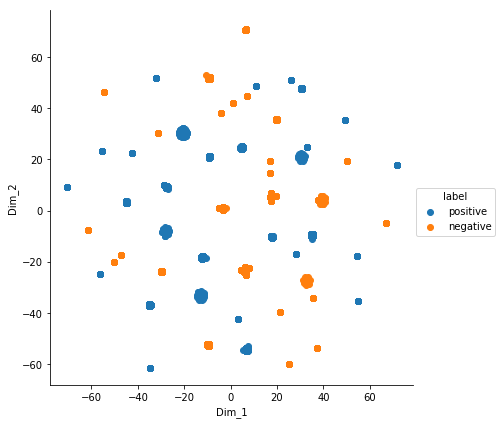

In [50]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [51]:
# Building t-SNE for AvgW2Vec with Perplexity 50 and n_iter=2000
from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2,perplexity=50,n_iter=2000, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

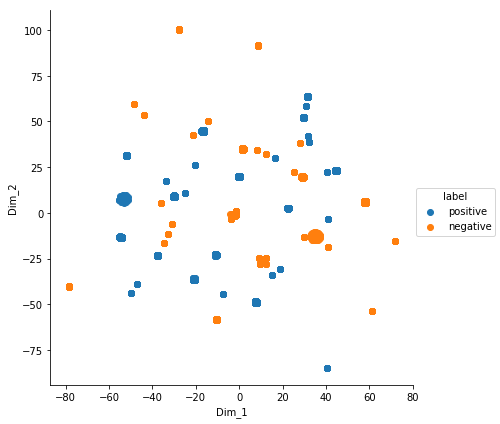

In [52]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF Weighted W2Vec

In [54]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_postive_negative['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [74]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val= tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent):# for each review/sentence
    sent_vec = np.zeros(50)# as word vectors are of zero length
    weight_sum =0;# num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        


  2%|█▍                                                                         | 6756/366208 [00:09<06:41, 894.80it/s]


  4%|██▉                                                                       | 14825/366208 [00:18<09:02, 647.68it/s]


  4%|███▎                                                                     | 16364/366208 [00:28<1:01:25, 94.93it/s]


  5%|███▌                                                                      | 17451/366208 [00:36<34:01, 170.87it/s]


  5%|███▊                                                                     | 19225/366208 [00:46<1:03:13, 91.47it/s]


  6%|████▏                                                                     | 20960/366208 [00:54<36:46, 156.44it/s]


  6%|████▋                                                                     | 23495/366208 [01:02<23:53, 239.03it/s]


  8%|█████▋                                                                    | 28185/366208 [01:12<08:51, 635.67it/s]


 10%|███████                                                                   | 34921/366208 [01:22<19:27, 283.70it/s]


 10%|███████▍                                                                  | 36750/366208 [01:31<12:35, 436.25it/s]


 11%|███████▊                                                                 | 39403/366208 [01:42<1:43:05, 52.84it/s]


 11%|███████▉                                                                 | 39808/366208 [01:50<1:42:35, 53.03it/s]


 11%|████████                                                                 | 40216/366208 [01:57<1:43:02, 52.73it/s]


 11%|████████                                                                 | 40619/366208 [02:05<1:41:39, 53.38it/s]


 11%|████████▍                                                                 | 42014/366208 [02:14<25:03, 215.58it/s]


 12%|████████▉                                                                 | 44371/366208 [02:22<39:30, 135.75it/s]


 13%|█████████▎                                                                | 46145/366208 [02:30<23:08, 230.54it/s]


 13%|█████████▌                                                                | 47615/366208 [02:38<33:41, 157.62it/s]


 14%|██████████▌                                                               | 52125/366208 [02:47<11:50, 441.97it/s]


 15%|██████████▉                                                               | 54351/366208 [02:56<36:06, 143.94it/s]


 16%|███████████▊                                                              | 58409/366208 [03:04<06:58, 735.71it/s]


 18%|█████████████                                                             | 64782/366208 [03:15<41:47, 120.23it/s]


 18%|█████████████▌                                                            | 66935/366208 [03:23<11:34, 431.22it/s]


 20%|██████████████▉                                                           | 74048/366208 [03:32<06:08, 793.30it/s]


 22%|████████████████▋                                                         | 82297/366208 [03:41<06:32, 722.60it/s]


 24%|█████████████████▋                                                        | 87421/366208 [03:50<12:53, 360.32it/s]


 25%|██████████████████▍                                                       | 91003/366208 [04:00<07:42, 595.34it/s]


 26%|███████████████████▍                                                      | 95986/366208 [04:08<05:15, 857.70it/s]


 28%|████████████████████▎                                                   | 103252/366208 [04:18<03:55, 1118.56it/s]


 30%|█████████████████████▉                                                   | 109988/366208 [04:27<09:54, 430.86it/s]


 31%|██████████████████████▉                                                  | 115019/366208 [04:37<33:16, 125.81it/s]


 32%|███████████████████████▋                                                 | 118609/366208 [04:45<06:54, 597.50it/s]


 33%|████████████████████████▍                                                | 122527/366208 [04:54<13:19, 304.94it/s]


 34%|████████████████████████▉                                                 | 123432/366208 [05:02<43:24, 93.20it/s]


 34%|█████████████████████████▏                                               | 126144/366208 [05:10<12:45, 313.46it/s]


 36%|██████████████████████████                                               | 130762/366208 [05:19<08:08, 482.46it/s]


 37%|██████████████████████████▊                                              | 134300/366208 [05:28<20:31, 188.39it/s]


 37%|██████████████████████████▉                                              | 135284/366208 [05:36<35:07, 109.58it/s]


 38%|███████████████████████████▌                                             | 138363/366208 [05:44<12:12, 310.87it/s]


 39%|████████████████████████████▍                                            | 142529/366208 [05:53<05:02, 740.00it/s]


 40%|█████████████████████████████                                            | 146023/366208 [06:02<13:27, 272.83it/s]


 40%|█████████████████████████████▍                                           | 147667/366208 [06:11<34:42, 104.92it/s]


 41%|█████████████████████████████▉                                           | 150405/366208 [06:19<09:11, 391.43it/s]


 42%|██████████████████████████████▊                                           | 152448/366208 [06:28<36:22, 97.95it/s]


 42%|██████████████████████████████▋                                          | 153722/366208 [06:35<21:05, 167.91it/s]


 43%|███████████████████████████████▏                                         | 156531/366208 [06:43<04:32, 770.39it/s]


 44%|████████████████████████████████▍                                        | 162692/366208 [06:52<03:38, 930.82it/s]


 46%|█████████████████████████████████▋                                       | 168935/366208 [07:01<05:20, 615.96it/s]


 47%|██████████████████████████████████▋                                      | 173922/366208 [07:11<17:36, 182.02it/s]


 49%|███████████████████████████████████▊                                     | 179743/366208 [07:21<05:22, 577.37it/s]


 50%|████████████████████████████████████▋                                    | 184201/366208 [07:30<06:05, 497.81it/s]


 52%|█████████████████████████████████████▋                                   | 189373/366208 [07:41<07:39, 384.99it/s]


 53%|██████████████████████████████████████▊                                  | 194713/366208 [07:50<03:58, 719.38it/s]


 55%|████████████████████████████████████████                                 | 200820/366208 [08:00<06:20, 435.10it/s]


 56%|█████████████████████████████████████████                                | 206009/366208 [08:10<03:19, 803.98it/s]


 57%|██████████████████████████████████████████▍                               | 209929/366208 [08:21<28:31, 91.28it/s]


 58%|██████████████████████████████████████████                               | 211098/366208 [08:29<17:40, 146.22it/s]


 58%|██████████████████████████████████████████▌                              | 213666/366208 [08:37<07:12, 352.98it/s]


 60%|███████████████████████████████████████████▌                             | 218493/366208 [08:47<20:11, 121.91it/s]


 60%|████████████████████████████████████████████                             | 220934/366208 [08:55<06:14, 387.99it/s]


 61%|████████████████████████████████████████████▋                            | 224244/366208 [09:03<05:42, 415.10it/s]


 62%|█████████████████████████████████████████████▍                           | 227904/366208 [09:12<09:36, 239.81it/s]


 63%|█████████████████████████████████████████████▊                           | 229670/366208 [09:20<13:12, 172.19it/s]


 64%|██████████████████████████████████████████████▌                          | 233767/366208 [09:28<02:55, 754.50it/s]


 65%|███████████████████████████████████████████████▏                         | 236890/366208 [09:38<07:56, 271.12it/s]


 66%|████████████████████████████████████████████████                         | 241143/366208 [09:48<07:02, 296.16it/s]


 68%|█████████████████████████████████████████████████▍                       | 247989/366208 [09:57<02:24, 818.88it/s]


 70%|██████████████████████████████████████████████████▊                      | 255111/366208 [10:07<04:26, 416.78it/s]


 72%|███████████████████████████████████████████████████▌                    | 262012/366208 [10:16<01:40, 1032.27it/s]


 73%|████████████████████████████████████████████████████▉                   | 269092/366208 [10:26<01:23, 1169.99it/s]


 75%|██████████████████████████████████████████████████████▊                  | 274868/366208 [10:36<06:19, 240.67it/s]


 76%|███████████████████████████████████████████████████████▍                 | 277799/366208 [10:44<03:40, 401.30it/s]


 78%|████████████████████████████████████████████████████████▊                | 285188/366208 [10:52<01:21, 990.93it/s]


 80%|██████████████████████████████████████████████████████████               | 291470/366208 [11:02<04:20, 286.67it/s]


 81%|███████████████████████████████████████████████████████████▎             | 297381/366208 [11:11<03:36, 317.41it/s]


 83%|████████████████████████████████████████████████████████████▌            | 303805/366208 [11:21<04:01, 258.01it/s]


 84%|█████████████████████████████████████████████████████████████            | 306418/366208 [11:32<09:57, 100.09it/s]


 85%|█████████████████████████████████████████████████████████████▉           | 310523/366208 [11:42<01:13, 754.71it/s]


 86%|███████████████████████████████████████████████████████████████          | 316620/366208 [11:51<02:27, 336.50it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 323727/366208 [12:00<01:55, 366.33it/s]


 90%|█████████████████████████████████████████████████████████████████▊       | 330346/366208 [12:09<00:42, 836.95it/s]


 92%|███████████████████████████████████████████████████████████████████▎     | 337609/366208 [12:18<00:30, 946.50it/s]


 94%|████████████████████████████████████████████████████████████████████▌    | 343990/366208 [12:28<01:12, 306.80it/s]


 95%|█████████████████████████████████████████████████████████████████████▍   | 348316/366208 [12:36<00:35, 506.28it/s]


 96%|██████████████████████████████████████████████████████████████████████▎  | 352605/366208 [12:46<00:28, 473.35it/s]


 98%|███████████████████████████████████████████████████████████████████████▋ | 359688/366208 [12:56<00:12, 507.97it/s]


100%|█████████████████████████████████████████████████████████████████████████| 366208/366208 [13:05<00:00, 466.31it/s]

In [78]:
print(len(tfidf_sent_vectors))

68369171


# t_SNE on TFIDF AvgWord2Vec

In [79]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler

# Converter to toarry()
standardized_data = StandardScaler(with_mean='True').fit_transform(sent_vectors[0:4000])
print(standardized_data.shape)

(4000, 50)


In [80]:
# Building t-SNE for AvgW2Vec with Perplexity 50 and n_iter=2000
from sklearn.manifold import TSNE

data= standardized_data[0:,:]
labels= Labels[0:]

model = TSNE(n_components=2,perplexity=50,n_iter=2000, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

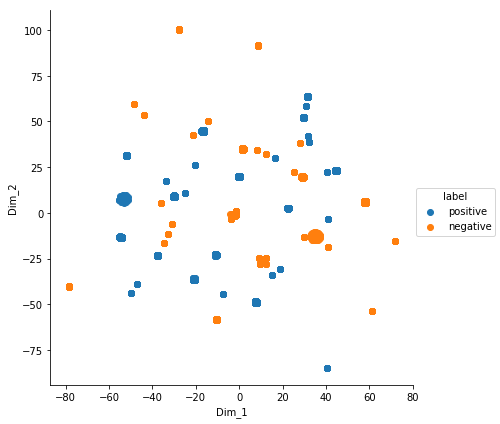

In [81]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()